In [1]:
# 경로설정
import sys
path = "C:\github/aide-analysis/"
path2 = 'C:\github/aide-analysis/notebook/temp_ljs/Develop/지주리포트Lite/실거래 이상값 제거 연구 및 추론/모듈 및 압축파일 보관 폴더'
sys.path.append(path)
sys.path.append(path2)

import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd())))
# 한글폰트
import os
import matplotlib.pyplot as plt
if os.name =='posix':
    plt.rc('font',family = 'ApplGothic')
else:
    plt.rc('font',family = 'Malgun Gothic')
    
# 경고출력문 제거
import warnings
warnings.filterwarnings("ignore")

# 모듈 import
import pandas as pd
import src
from src.openapi import KakaoLocalAPI as kakao
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from src.sql import DatabaseHandler
from src.temp import *
from datetime import datetime
import datetime
from dateutil.relativedelta import relativedelta
from src.bigquery import BigqueryHandler
import seaborn as sns
import numpy as np
import statistics
from tqdm import tqdm
import config
from core.config import Config
import json
from datetime import datetime
import geopandas as gpd
from tqdm import tqdm
import folium
from src.bigquery import bigquery_client, bigquery
import geopandas as gpd
from shapely import wkt
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from openpyxl.utils.dataframe import dataframe_to_rows
from difflib import SequenceMatcher
import openpyxl
import math
from dataclasses import dataclass
config = Config()
BH = BigqueryHandler()


# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

## 가격 

- 특정 단지의 가격
    - 모든 타입 매매 평당가 평균으로 추세
    - 면적 구간별 매매 평당가 추세 (전세도 같이 표현) --> 전세를 같이표현하는 이유는 전세가의 움직임과 함께보면서 단지의 특성파악을 위함
    - 59/84에 해당하는 면적에 대한 매매 평당가 (전세도 같이 표현)
- 반경 1km, 2km, 시군구, 시도내 단지들의 가격
    - 면적구간별/ 59 / 84 에 따른 평균 가격흐름
    - 구간내 세대수가 가장 많은 단지들 의 움직임 별도 표현
    - 특정 단지와 유사한 단지들의 흐름
    - 신,구축,일반에 따른 가격움직임 흐름


## 거래량
- 외형가 6억이상 9억이상 15억이상 3억이상 3억이하에 따른 거래량
- 전세 거래량, 매매 거래량, 월세 거래량
- 면적 그룹별 거래량
- 59/84 거래량

In [59]:
docs

{'documents': [{'address': {'address_name': '서울 강서구 마곡동 743-4',
    'b_code': '1150010500',
    'h_code': '1150063000',
    'main_address_no': '743',
    'mountain_yn': 'N',
    'region_1depth_name': '서울',
    'region_2depth_name': '강서구',
    'region_3depth_h_name': '방화1동',
    'region_3depth_name': '마곡동',
    'sub_address_no': '4',
    'x': '126.823376663134',
    'y': '37.5648812125749'},
   'address_name': '서울 강서구 마곡동 743-4',
   'address_type': 'REGION_ADDR',
   'road_address': {'address_name': '서울 강서구 마곡서로 133',
    'building_name': '마곡엠밸리7단지',
    'main_building_no': '133',
    'region_1depth_name': '서울',
    'region_2depth_name': '강서구',
    'region_3depth_name': '마곡동',
    'road_name': '마곡서로',
    'sub_building_no': '',
    'underground_yn': 'N',
    'x': '126.823838667719',
    'y': '37.5645561030039',
    'zone_no': '07798'},
   'x': '126.823376663134',
   'y': '37.5648812125749'}],
 'meta': {'is_end': True, 'pageable_count': 1, 'total_count': 1}}

In [38]:
docs = kakao.search_address('서울시 강서구 마곡동 743-4')

In [44]:
sidoCode = docs['documents'][0]['address']['b_code'][:2]
sigunguCode = docs['documents'][0]['address']['b_code'][:5]
bdongCode = docs['documents'][0]['address']['b_code'][:10]
lon = docs['documents'][0]['address']['x']
lat = docs['documents'][0]['address']['y']

In [4]:
sql = f"""
SELECT complexNo, 
       complexName, 
       sigunguCode, 
       bdongCode, 
       address, 
       totalHouseholdCount,
       useApproveYear,
       CASE
       WHEN useApproveYear >='2018'THEN "new"
       WHEN useApproveYear < "2018" AND useApproveYear >= "2003" THEN "normal"
       WHEN useApproveYear < "2003" THEN "old" END AS status,
       supplyArea,
       supplyPyeong,
       jeonyongArea,
       jeonyongPyeong,
       areaSixGroupNo,
       tradeType,
       dealPrice,
       pricePerSupplyPyeong,
       averagePyeong,
       averagePrice,
       isFloor,
       isProcessing1,
       isProcessing2,
       isProcessing3,
       interpolate,
       isReal,
       yearMonth,
       predict
FROM `aidepartners.aide.aide_apartment_price_origin`
WHERE sidoCode = "{sidoCode}" and yearMonth >='2013-01-01' AND totalHouseholdCount>=100
"""
# 시도
df = BH.read_table(sql)
# dbdate to datetime
df['yearMonth'] = pd.to_datetime(df['yearMonth'])

#  필터로 걸러진 거래의 averagePyeong, averagePrice컬럼 은 nan값으로 변경해주기
df.loc[(df['isFloor']==True)|(df['isProcessing1']==True)|(df['isProcessing2']==True)|(df['isProcessing3']==True),['averagePyeong','averagePrice']] = np.nan

In [5]:
# 시군구
df_sigungu = df[df['sigunguCode']==sigunguCode].reset_index(drop =True)
# 법정동
df_bdong = df[df['bdongCode']==bdongCode].reset_index(drop =True)

# Ad-Hoc

## 10년간 월별 거래량

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123]),
 [Text(0, 0, '2013-1'),
  Text(1, 0, '2013-2'),
  Text(2, 0, '2013-3'),
  Text(3, 0, '2013-4'),
  Text(4, 0, '2013-5'),
  Text(5, 0, '2013-6'),
  Text(6, 0, '2013-7'),
  Text(7, 0, '2013-8'),
  Text(8, 0, '2013-9'),
  Text(9, 0, '2013-10'),
  Text(10, 0, '2013-11'),
  Text(11, 0, '2013-12'),
  Tex

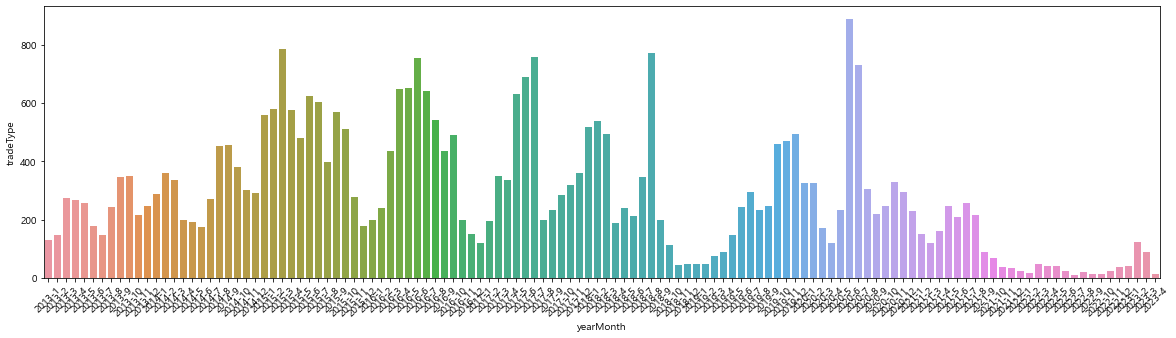

In [6]:
df_tradingYear = df_sigungu[df_sigungu['isReal']==True].groupby('yearMonth')['tradeType'].count().reset_index()
# 연도컬럼 생성
df_tradingYear['year'] = df_tradingYear['yearMonth'].dt.year
# 년-월
df_tradingYear['yearMonth'] = df_tradingYear['yearMonth'].dt.year.astype(str) +'-'+df_tradingYear['yearMonth'].dt.month.astype(str)
# 시각화
plt.figure(figsize = (20, 5))
sns.barplot(df_tradingYear['yearMonth'], df_tradingYear['tradeType'])

plt.xticks(rotation=45)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121]),
 [Text(0, 0, '2013-1'),
  Text(1, 0, '2013-2'),
  Text(2, 0, '2013-3'),
  Text(3, 0, '2013-4'),
  Text(4, 0, '2013-5'),
  Text(5, 0, '2013-6'),
  Text(6, 0, '2013-7'),
  Text(7, 0, '2013-8'),
  Text(8, 0, '2013-9'),
  Text(9, 0, '2013-10'),
  Text(10, 0, '2013-11'),
  Text(11, 0, '2013-12'),
  Text(12, 0, '

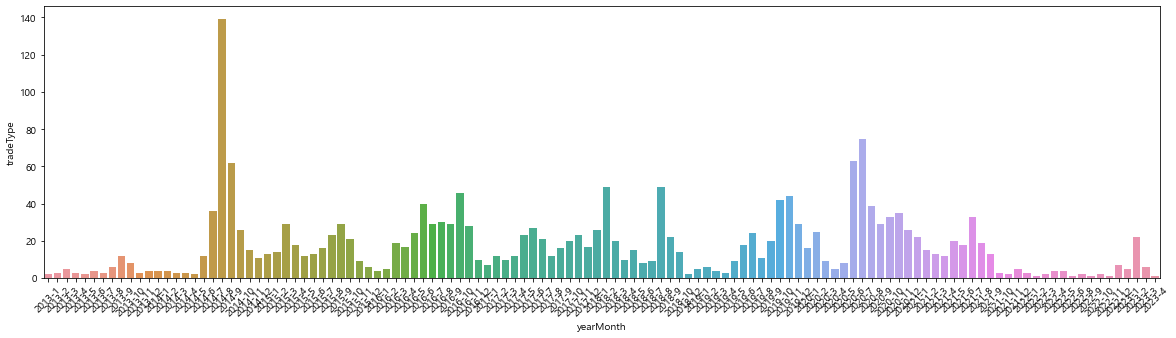

In [7]:
df_tradingYearBdong = df_bdong[df_bdong['isReal']==True].groupby('yearMonth')['tradeType'].count().reset_index()
# 연도컬럼 생성
df_tradingYearBdong['year'] = df_tradingYearBdong['yearMonth'].dt.year
# 년-월
df_tradingYearBdong['yearMonth'] = df_tradingYearBdong['yearMonth'].dt.year.astype(str) +'-'+df_tradingYearBdong['yearMonth'].dt.month.astype(str)
# 시각화
plt.figure(figsize = (20, 5))
sns.barplot(df_tradingYearBdong['yearMonth'], df_tradingYearBdong['tradeType'])
plt.xticks(rotation=45)

## 연간 세대수

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


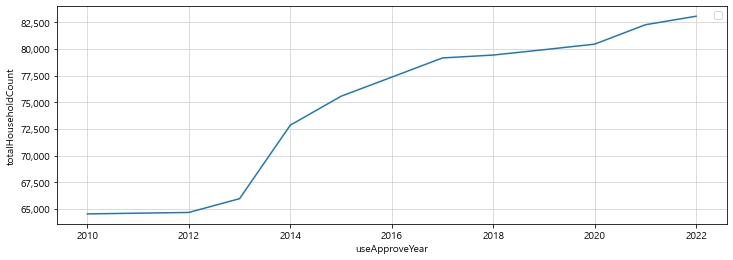

In [8]:
# 실제거래가 된 데이터 추출
df_sigunguReal = df_sigungu[df_sigungu['isReal']==True].drop_duplicates(subset = 'complexNo').reset_index(drop =True)
# 연도별 총 세대수 합계데이터 
df_sigunguSedae = df_sigunguReal.groupby('useApproveYear')['totalHouseholdCount'].sum().reset_index()
# 연도별 누적합 데이터프레임으로 변환
df_sigunguSedaeCount = pd.concat([df_sigunguSedae['useApproveYear'], df_sigunguSedae['totalHouseholdCount'].cumsum()],axis =1)
# 2010년도 이전 데이터 제거
df_sigunguSedaeCount = df_sigunguSedaeCount[df_sigunguSedaeCount['useApproveYear']>='2010'].reset_index(drop =True)
# 타입변경
df_sigunguSedaeCount['useApproveYear'] = df_sigunguSedaeCount['useApproveYear'].astype(int)

plt.figure(figsize = (12, 4))
sns.lineplot(df_sigunguSedaeCount['useApproveYear'], df_sigunguSedaeCount['totalHouseholdCount'])

# y축 설정
current_values =plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

# grid 설정
plt.grid(axis = "y", c = "lightgray")
plt.grid(axis = "x", c = "lightgray")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


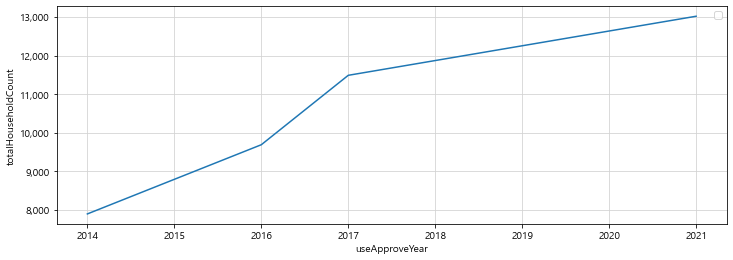

In [9]:
# 실제거래가 된 데이터 추출
df_bdongReal = df_bdong[df_bdong['isReal']==True].drop_duplicates(subset = 'complexNo').reset_index(drop =True)
# 연도별 총 세대수 합계데이터 
df_bdongSedae = df_bdongReal.groupby('useApproveYear')['totalHouseholdCount'].sum().reset_index()
# 연도별 누적합 데이터프레임으로 변환
df_bdongSedaeCount = pd.concat([df_bdongSedae['useApproveYear'], df_bdongSedae['totalHouseholdCount'].cumsum()],axis =1)
# 2010년도 이전 데이터 제거
df_bdongSedaeCount = df_bdongSedaeCount[df_bdongSedaeCount['useApproveYear']>='2010'].reset_index(drop =True)
# 타입변경
df_bdongSedaeCount['useApproveYear'] = df_bdongSedaeCount['useApproveYear'].astype(int)

plt.figure(figsize = (12, 4))
sns.lineplot(df_bdongSedaeCount['useApproveYear'], df_bdongSedaeCount['totalHouseholdCount'])
# y축 설정
current_values =plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

# grid 설정
plt.grid(axis = "y", c = "lightgray")
plt.grid(axis = "x", c = "lightgray")
plt.legend()

## 연간 회전율

In [10]:
df_sigungu[df_sigungu['yearMonth']>='2017-01-01']

,complexNo,complexName,sigunguCode,bdongCode,address,totalHouseholdCount,useApproveYear,status,supplyArea,supplyPyeong,jeonyongArea,jeonyongPyeong,areaSixGroupNo,tradeType,dealPrice,pricePerSupplyPyeong,averagePyeong,averagePrice,isFloor,isProcessing1,isProcessing2,isProcessing3,interpolate,isReal,yearMonth,predict
0,34,삼성관음,11500,1150010100,서울시 강서구 염창동,350,1997,old,141.57,42.82,114.90,34.75,A4,A1,890000000,20784680,2.116418e+07,9.062500e+08,False,False,False,False,False,True,2020-07-01,False
1,34,삼성관음,11500,1150010100,서울시 강서구 염창동,350,1997,old,108.63,32.86,84.93,25.69,A3,A1,800000000,24345709,2.434571e+07,8.000000e+08,False,False,False,False,False,True,2020-07-01,False
2,35,삼성하나로,11500,1150010100,서울시 강서구 염창동,178,1994,old,104.20,31.52,84.78,25.64,A3,A1,715000000,22684010,2.298541e+07,7.245000e+08,False,False,False,False,False,True,2020-10-01,False
4,35,삼성하나로,11500,1150010100,서울시 강서구 염창동,178,1994,old,104.20,31.52,84.78,25.64,A3,A1,<NA>,<NA>,2.006662e+07,6.325000e+08,False,False,False,False,True,False,2020-01-01,False
6,35,삼성하나로,11500,1150010100,서울시 강서구 염창동,178,1994,old,104.20,31.52,84.78,25.64,A3,A1,<NA>,<NA>,2.601523e+07,8.200000e+08,False,False,False,False,True,False,2022-09-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70450,27330,강서센트레빌3차,11500,1150010900,서울시 강서구 방화동,147,2009,normal,80.90,24.47,59.83,18.09,A2,A1,<NA>,<NA>,2.441915e+07,5.975366e+08,False,False,False,False,True,False,2018-11-01,False
70452,27330,강서센트레빌3차,11500,1150010900,서울시 강서구 방화동,147,2009,normal,80.90,24.47,59.83,18.09,A2,A1,<NA>,<NA>,2.740140e+07,6.705122e+08,False,False,False,False,True,False,2020-03-01,False
70453,27330,강서센트레빌3차,11500,1150010900,서울시 강서구 방화동,147,2009,normal,113.40,34.30,84.40,25.53,A3,A1,<NA>,<NA>,2.344484e+07,8.041579e+08,False,False,False,False,True,False,2020-10-01,False
70454,102228,월드메르디앙(878),11500,1150010900,서울시 강서구 방화동,100,2004,normal,107.24,32.44,84.93,25.69,A3,A1,<NA>,<NA>,1.717016e+07,5.570000e+08,False,False,False,False,True,False,2019-09-01,False


<AxesSubplot:xlabel='year', ylabel='rotation'>

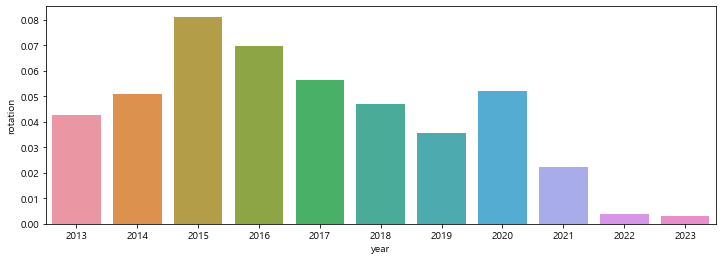

In [11]:
# 연간 거래량 테이블 만들기
df_tradingYear2 = df_tradingYear.groupby('year')['tradeType'].sum().reset_index()
# 연간 총세대수 누적테이블과 merge
df_rotationRatio = pd.merge(df_tradingYear2, df_sigunguSedaeCount, left_on = 'year', right_on = 'useApproveYear', how = 'left')
# 입주물량이없는 연도는 이전연도로 채우기
df_rotationRatio['totalHouseholdCount'] = df_rotationRatio['totalHouseholdCount'].fillna(method = 'ffill')
# 연간회전율 컬럼 만들기
df_rotationRatio['rotation'] = df_rotationRatio['tradeType']/ df_rotationRatio['totalHouseholdCount']
# 시각화
plt.figure(figsize = (12,4))
sns.barplot(df_rotationRatio['year'], df_rotationRatio['rotation'])


<AxesSubplot:xlabel='year', ylabel='rotation'>

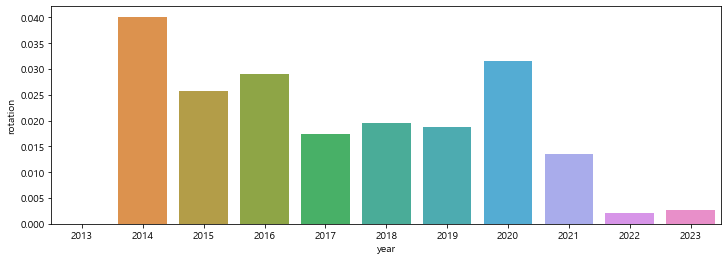

In [12]:
# 연간 거래량 테이블 만들기
df_tradingYearBdong2 = df_tradingYearBdong.groupby('year')['tradeType'].sum().reset_index()
# 연간 총세대수 누적테이블과 merge
df_rotationRatioBdong = pd.merge(df_tradingYearBdong2, df_bdongSedaeCount, left_on = 'year', right_on = 'useApproveYear', how = 'left')
# 입주물량이없는 연도는 이전연도로 채우기
df_rotationRatioBdong['totalHouseholdCount'] = df_rotationRatioBdong['totalHouseholdCount'].fillna(method = 'ffill')
# 연간회전율 컬럼 만들기
df_rotationRatioBdong['rotation'] = df_rotationRatioBdong['tradeType']/ df_rotationRatioBdong['totalHouseholdCount']
# 시각화
plt.figure(figsize = (12,4))
sns.barplot(df_rotationRatioBdong['year'], df_rotationRatioBdong['rotation'])

## 면적그룹별 거래량

In [13]:
df_sigungu['year'] = df_sigungu['yearMonth'].dt.year
df_sigunguCount = df_sigungu[df_sigungu['isReal']==True].groupby('areaSixGroupNo')['tradeType'].count().reset_index()
df_sigunguCount

,areaSixGroupNo,tradeType
0,A0,1668
1,A1,5481
2,A2,9401
3,A3,14201
4,A4,2709
5,A5,2264


<AxesSubplot:xlabel='year', ylabel='tradeType'>

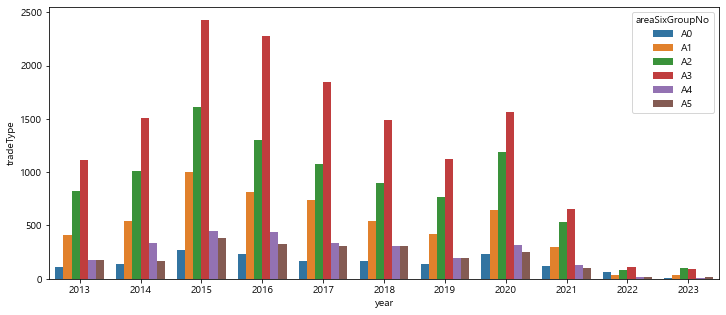

In [14]:
df_sigunguAreaCount = df_sigungu[df_sigungu['isReal']==True].groupby(['year','areaSixGroupNo'])['tradeType'].count().reset_index()
plt.figure(figsize =(12, 5))
sns.barplot(df_sigunguAreaCount['year'], df_sigunguAreaCount['tradeType'], hue = df_sigunguAreaCount['areaSixGroupNo'])

In [15]:
df_bdong['year'] = df_bdong['yearMonth'].dt.year
df_bdong[df_bdong['isReal']==True].groupby('areaSixGroupNo')['tradeType'].count().reset_index()

,areaSixGroupNo,tradeType
0,A2,502
1,A3,1207
2,A4,386


<AxesSubplot:xlabel='year', ylabel='tradeType'>

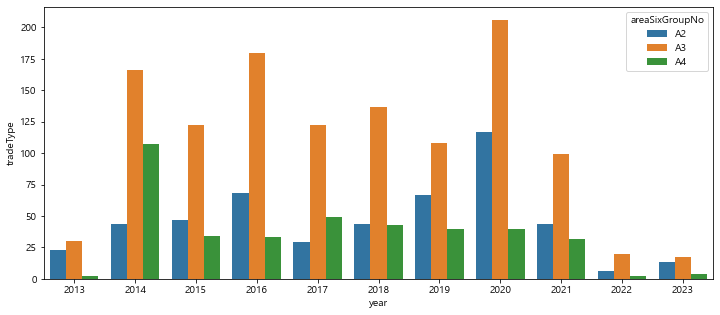

In [16]:
df_bdongAreaCount = df_bdong[df_bdong['isReal']==True].groupby(['year','areaSixGroupNo'])['tradeType'].count().reset_index()
plt.figure(figsize = (12, 5))
sns.barplot(df_bdongAreaCount['year'],df_bdongAreaCount['tradeType'], hue = df_bdongAreaCount['areaSixGroupNo'])

## 면적그룹별 세대수

In [17]:
df_sigungu.drop_duplicates(subset = ['complexNo','areaSixGroupNo']).groupby(['areaSixGroupNo'])['complexName'].count().reset_index()


,areaSixGroupNo,complexName
0,A0,21
1,A1,31
2,A2,120
3,A3,160
4,A4,74
5,A5,24


In [18]:
df_bdong.drop_duplicates(subset = ['complexNo','areaSixGroupNo']).groupby(['areaSixGroupNo'])['complexName'].count().reset_index()

,areaSixGroupNo,complexName
0,A1,1
1,A2,11
2,A3,21
3,A4,12


# 분석

## 노후 상태

In [19]:
df_old = df_sigungu.drop_duplicates(subset = 'complexNo').groupby('status')['complexNo'].count().reset_index()
# 비율도 생성
total = df_old['complexNo'].sum()
df_old['pct'] = df_old['complexNo']/ total *100
df_old
df_old

,status,complexNo,pct
0,new,14,7.070707
1,normal,83,41.919192
2,old,101,51.010101


In [20]:
df_oldBdong = df_bdong.drop_duplicates(subset = 'complexNo').groupby('status')['complexNo'].count().reset_index()
# 비율도 생성
total2 = df_oldBdong['complexNo'].sum()
df_oldBdong['pct'] = df_oldBdong['complexNo']/total2*100
df_oldBdong

,status,complexNo,pct
0,new,1,4.761905
1,normal,17,80.952381
2,old,3,14.285714


# 대장단지

## 가장 최근 거래별 대장단지(시군군)

In [22]:
# 실제거래 필터
df_big = df_sigungu[-df_sigungu['dealPrice'].isna()].reset_index(drop =True)
# 가장 마지막 거래일자 필터 
df_bigYear = df_big.groupby(['complexName','areaSixGroupNo'])['yearMonth'].max().reset_index()
# 마지막 거래일자에 해당하는 가격 넣기
df_lastPrice = pd.merge(df_bigYear, df_sigungu[-df_sigungu['dealPrice'].isna()], on = ['complexName','areaSixGroupNo','yearMonth'], how= 'left')
df_lastPrice =df_lastPrice[['complexNo','complexName','areaSixGroupNo','yearMonth','pricePerSupplyPyeong','dealPrice']]
df_lastPrice.sort_values(by = 'pricePerSupplyPyeong',ascending = False).iloc[:5].reset_index(drop =True)

,complexNo,complexName,areaSixGroupNo,yearMonth,pricePerSupplyPyeong,dealPrice
0,115965,e편한세상염창,A2,2021-08-01,54825462,1335000000
1,107505,마곡엠밸리15단지,A2,2021-09-01,52295409,1310000000
2,108359,마곡힐스테이트,A2,2022-06-01,50950263,1260000000
3,112281,마곡엠밸리12단지,A3,2021-09-01,45967520,1670000000
4,103293,강서한강자이,A2,2021-08-01,45058690,1190000000


## 추정거래가격에 따른 대장단지(시군구)

In [23]:
df_sigungu.loc[df_sigungu['yearMonth']=='2023-04-01',['complexNo','complexName','areaSixGroupNo','yearMonth','averagePyeong','averagePrice']].sort_values(by = 'averagePyeong',ascending =False).iloc[:5].reset_index()

,index,complexNo,complexName,areaSixGroupNo,yearMonth,averagePyeong,averagePrice
0,37081,127604,마곡센트레빌,A1,2023-04-01,4.081633e+07,8.000000e+08
1,39626,115965,e편한세상염창,A2,2023-04-01,4.071146e+07,9.701541e+08
2,45936,11565,염창한화꿈에그린1차,A2,2023-04-01,3.889537e+07,1.000000e+09
3,63864,107477,마곡엠밸리7단지,A3,2023-04-01,3.885885e+07,1.287782e+09
4,65461,108359,마곡힐스테이트,A2,2023-04-01,3.870926e+07,9.572799e+08


In [24]:
# 거래가 한번도 없어서 추정하지 못하는 단지
df_sigungu.loc[(df_sigungu['yearMonth']=='2023-04-01')&(df_sigungu['averagePyeong'].isna()),['complexNo','complexName','areaSixGroupNo','yearMonth','averagePyeong','averagePrice']].sort_values(by = 'averagePyeong',ascending =False).reset_index(drop =True)

,complexNo,complexName,areaSixGroupNo,yearMonth,averagePyeong,averagePrice
0,127100,가양역두산위브,A0,2023-04-01,NaN,NaN
1,127604,마곡센트레빌,A3,2023-04-01,NaN,NaN
2,147881,그레이스힐(주상복합),A3,2023-04-01,NaN,NaN
3,111101,서울시니어스강서타워(주상복합),A3,2023-04-01,NaN,NaN
4,131485,우장산숲아이파크,A2,2023-04-01,NaN,NaN
5,27308,"서울시니어스가양타워(실버주택,주상복합)",A0,2023-04-01,NaN,NaN
6,127100,가양역두산위브,A3,2023-04-01,NaN,NaN
7,111101,서울시니어스강서타워(주상복합),A4,2023-04-01,NaN,NaN
8,1012,강나루현대,A2,2023-04-01,NaN,NaN
9,25875,청솔숲속마을,A2,2023-04-01,NaN,NaN


- 신,구축,일반 평단가 평균

## 가장 최근 거래별 대장단지(법정동)

In [25]:
# 실제거래 필터
df_bigBdong = df_bdong[-df_bdong['dealPrice'].isna()].reset_index(drop =True)
# 가장 마지막 거래일자 필터 
df_bigYearBdong = df_bigBdong.groupby(['complexName','areaSixGroupNo'])['yearMonth'].max().reset_index()
# 마지막 거래일자에 해당하는 가격 넣기
df_lastPriceBdong = pd.merge(df_bigYearBdong, df_bdong[-df_bdong['dealPrice'].isna()], on = ['complexName','areaSixGroupNo','yearMonth'], how= 'left')
df_lastPriceBdong =df_lastPriceBdong[['complexNo','complexName','areaSixGroupNo','yearMonth','pricePerSupplyPyeong','dealPrice']]
df_lastPriceBdong.sort_values(by = 'pricePerSupplyPyeong',ascending = False).iloc[:5].reset_index(drop =True)

,complexNo,complexName,areaSixGroupNo,yearMonth,pricePerSupplyPyeong,dealPrice
0,107505,마곡엠밸리15단지,A2,2021-09-01,52295409,1310000000
1,108359,마곡힐스테이트,A2,2022-06-01,50950263,1260000000
2,112281,마곡엠밸리12단지,A3,2021-09-01,45967520,1670000000
3,107475,마곡엠밸리5단지,A4,2022-03-01,44956140,2050000000
4,112281,마곡엠밸리12단지,A2,2021-03-01,42438272,1100000000


## 추정거래가격에 따른 대장단지(법정동)

In [26]:
df_bdong.loc[df_bdong['yearMonth']=='2023-04-01',['complexNo','complexName','areaSixGroupNo','yearMonth','averagePyeong','averagePrice']].sort_values(by = 'averagePyeong',ascending =False).iloc[:5].reset_index()

,index,complexNo,complexName,areaSixGroupNo,yearMonth,averagePyeong,averagePrice
0,4790,107477,마곡엠밸리7단지,A3,2023-04-01,3.885885e+07,1.287782e+09
1,4930,108359,마곡힐스테이트,A2,2023-04-01,3.870926e+07,9.572799e+08
2,302,107506,마곡엠밸리6단지,A3,2023-04-01,3.821470e+07,1.310000e+09
3,196,112211,마곡엠밸리8단지,A2,2023-04-01,3.801101e+07,9.670000e+08
4,1337,109799,마곡13단지힐스테이트마스터,A2,2023-04-01,3.709336e+07,9.147222e+08


In [27]:
# 거래가 한번도 없어서 추정하지 못하는 단지
df_bdong.loc[(df_bdong['yearMonth']=='2023-04-01')&(df_bdong['averagePyeong'].isna()),['complexNo','complexName','areaSixGroupNo','yearMonth','averagePyeong','averagePrice']].sort_values(by = 'averagePyeong',ascending =False).reset_index(drop =True)

,complexNo,complexName,areaSixGroupNo,yearMonth,averagePyeong,averagePrice


# 유사 단지

지번 입력 -> 좌표 추출 -> 면적그룹 선택 -> 

In [83]:
sql = f"""
SELECT *, ST_DISTANCE(st_geogpoint({lon},{lat}), st_geogpoint(longitude, latitude)) AS distance
FROM `aidepartners.aide.complex_danji_information`
WHERE ST_DISTANCE(st_geogpoint({lon},{lat}), st_geogpoint(longitude, latitude))<=3000 
      AND realEstateTypeName = '아파트'
ORDER BY distance ASC
"""
df_sim = BH.read_table(sql)

In [85]:
useApproveYear = df_sim.loc[0,'useApproveYear']

In [86]:
str(pd.to_numeric(useApproveYear)-5)

'2009'

In [87]:
bYear = str(pd.to_numeric(useApproveYear)-5)
aYear = str(pd.to_numeric(useApproveYear)+5)

In [91]:
df_sim.loc[(df_sim['useApproveYear']>=bYear)&(df_sim['useApproveYear']<=aYear),['complexNo','complexName','totalHouseholdCount','useApproveYear','distance']]

,complexNo,complexName,totalHouseholdCount,useApproveYear,distance
0,107477,마곡엠밸리7단지,1004,2014,49.073273
1,107506,마곡엠밸리6단지,1466,2014,315.518384
3,112211,마곡엠밸리8단지,531,2016,360.946018
6,108359,마곡힐스테이트,603,2017,472.867729
7,107961,마곡엠밸리3단지,315,2014,475.710797
8,107483,마곡엠밸리4단지,420,2014,483.663941
10,107475,마곡엠밸리5단지,439,2014,528.499738
12,107960,마곡엠밸리2단지,408,2014,556.077023
13,107482,마곡엠밸리1단지,237,2014,566.393290
15,112281,마곡엠밸리12단지,363,2016,626.711939


In [89]:
if df_sim[(df_sim['useApproveYear']>=bYear)&(df_sim['useApproveYear']<=aYear)].shape[0] >=5:
    df_sim

# 플라워차트 test

In [2]:
sql = f"""
SELECT *
FROM `aidepartners.aide.complex_sales_real_estate`
WHERE sidoCode = '11'
"""
df = BH.read_table(sql)

In [15]:
df_a = df[df['complexNo']=='102233'].reset_index(drop =True)

In [18]:
df_a[['date','atclNo','tradTpNm']].sort_values(by = 'date')

,date,atclNo,tradTpNm
41,2022-07-25,2224196688,전세
364,2022-07-25,2224332319,매매
137,2022-07-25,2224333516,매매
516,2022-07-25,2224846262,전세
515,2022-07-25,2224635520,전세
...,...,...,...
285,2023-03-18,2309657170,매매
479,2023-03-18,2307964256,매매
356,2023-03-18,2310987523,월세
518,2023-03-18,2308912372,월세


In [19]:
df_a = df_a.drop_duplicates(subset = ['date','atclNo','tradTpNm']).reset_index(drop= True)

In [28]:
df_a_group = df_a.groupby(['date','tradTpNm'])['complexNo'].count().reset_index()
df_a_group

,date,tradTpNm,complexNo
0,2022-07-25,매매,9
1,2022-07-25,전세,4
2,2022-07-31,매매,9
3,2022-07-31,전세,5
4,2022-08-06,매매,9
5,2022-08-06,월세,1
6,2022-08-06,전세,5
7,2022-08-13,매매,11
8,2022-08-13,월세,1
9,2022-08-13,전세,6


In [33]:
df_a = df_a_group[df_a_group['tradTpNm']=='매매'].reset_index(drop =True)
df_b = df_a_group[df_a_group['tradTpNm']=='전세'].reset_index(drop= True)

In [40]:
df_total = pd.merge(df_a, df_b,on = 'date', how ='left')
df_total

,date,tradTpNm_x,complexNo_x,tradTpNm_y,complexNo_y
0,2022-07-25,매매,9,전세,4
1,2022-07-31,매매,9,전세,5
2,2022-08-06,매매,9,전세,5
3,2022-08-13,매매,11,전세,6
4,2022-08-20,매매,11,전세,7
5,2022-08-27,매매,13,전세,6
6,2022-09-03,매매,14,전세,4
7,2022-09-14,매매,14,전세,4
8,2022-09-17,매매,14,전세,4
9,2022-09-24,매매,14,전세,3


TypeError: float() argument must be a string or a real number, not 'list'

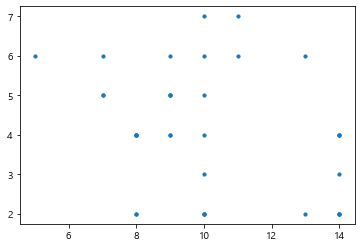

In [50]:
plt.scatter(df_total['complexNo_x'], df_total['complexNo_y'], s = 10)
grouped = df_total.groupby('date')
sizes = [i+1 for i in range(len(grouped))]

plt.plot(df_total['complexNo_x'], df_total['complexNo_y'], linewidth=sizes)
